In [ ]:
import os
from random import shuffle

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
from keras.applications.vgg16 import VGG16


import h5py


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

****

---

# functions


In [ ]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

In [ ]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [ ]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [ ]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [ ]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir_prueba, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            
            
            numer += 1

In [ ]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [ ]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

## Importing data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
in_dir = "/content/drive/MyDrive/GP/Data_set/N_ HockyFights/HockeyFights"
in_dir_prueba =  "/content/drive/MyDrive/GP/Data_set/N_ HockyFights/HockeyFights"
names, labels = label_video_names(in_dir)

In [ ]:
image_model = VGG16(include_top=True, weights='imagenet')


553476096/553467096 [==============================] - 5s 0us/step


In [ ]:
image_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
input_shape = image_model.layers[0].output_shape[1:3]
input_shape

[]

In [ ]:
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [ ]:
transfer_layer

In [ ]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [ ]:
make_files(training_set)


- Progress: 99.9%

In [ ]:
make_files_test(test_set)


- Progress: 99.5%

In [ ]:
data, target = process_alldata_training()
data_test, target_test = process_alldata_test()


In [ ]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [ ]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:750]), np.array(target[0:750]), epochs=epoch,
                    validation_data=(np.array(data[750:]), np.array(target[750:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/200
2/2 - 0s - loss: 0.0595 - accuracy: 0.9293 - val_loss: 0.0717 - val_accuracy: 0.9000
Epoch 2/200
2/2 - 0s - loss: 0.0561 - accuracy: 0.9400 - val_loss: 0.0698 - val_accuracy: 0.9000
Epoch 3/200
2/2 - 0s - loss: 0.0541 - accuracy: 0.9413 - val_loss: 0.0846 - val_accuracy: 0.9000
Epoch 4/200
2/2 - 0s - loss: 0.0592 - accuracy: 0.9280 - val_loss: 0.0703 - val_accuracy: 0.9000
Epoch 5/200
2/2 - 0s - loss: 0.0543 - accuracy: 0.9400 - val_loss: 0.0741 - val_accuracy: 0.9000
Epoch 6/200
2/2 - 0s - loss: 0.0533 - accuracy: 0.9373 - val_loss: 0.0775 - val_accuracy: 0.9000
Epoch 7/200
2/2 - 0s - loss: 0.0534 - accuracy: 0.9387 - val_loss: 0.0760 - val_accuracy: 0.9000
Epoch 8/200
2/2 - 0s - loss: 0.0524 - accuracy: 0.9400 - val_loss: 0.0782 - val_accuracy: 0.9000
Epoch 9/200
2/2 - 0s - loss: 0.0524 - accuracy: 0.9387 - val_loss: 0.0739 - val_accuracy: 0.9000
Epoch 10/200
2/2 - 0s - loss: 0.0517 - accuracy: 0.9400 - val_loss: 0.0747 - val_accuracy: 0.9000
Epoch 11/200
2/2 - 0s - loss:

In [ ]:
result = model.evaluate(np.array(data_test), np.array(target_test))


7/7 [==============================] - 0s 12ms/step - loss: 0.0502 - accuracy: 0.9400


In [ ]:
print(result)

[0.05018400773406029, 0.9399999976158142]


In [ ]:
model.save("model.h5")


In [ ]:
from keras.models import load_model
from numpy import loadtxt

# load model
model = load_model('model.h5')
# summarize model.
model.summary()
# load dataset

# evaluate the model
score = model.evaluate(np.array(data_test), np.array(target_test))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               9439232   
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                51250     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0

In [ ]:
print(score[1])

0.9399999976158142


In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.05018400773406029
accuracy 0.9399999976158142


In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.05018400773406029
accuracy 0.9399999976158142


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


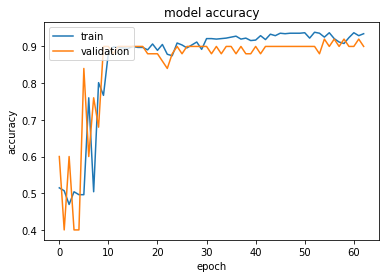

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


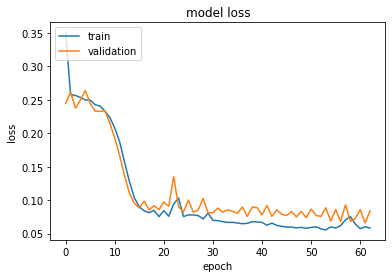

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()